In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import minimize

from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [3]:
data = loadmat('data/ex3data1.mat')

y = data['y']
X = np.c_[np.ones((data["X"].shape[0], 1)), data['X']]        # generates 5000x401 array

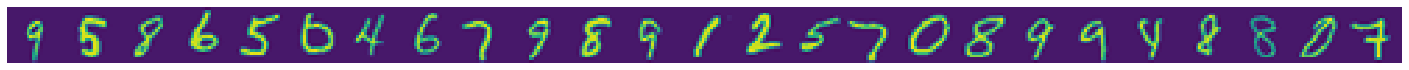

In [4]:
numbers = np.random.choice(X.shape[0], 25)
fig, ax = plt.subplots(1, figsize=(25,25))
plt.imshow(X[numbers, 1:].reshape(-1,20).T)
plt.axis('off');
plt.show()

# Important Points about scipy.optimize.minimize

<p>Minimize is a bit of a weird function. It is extremely sensitive about the dimensions of its inputs. Please note that passing, say, (5000, 1) could throw an error which is the case in <code>reg_gradient_lr</code> function; if you remove the <code>.reshape(-1, 1)</code> part of <code>h = sigmoid(X @ theta.reshape(-1, 1))</code>, the functions throws an error! although with and without reshape, we get (5000, 1).<p/>
<p>How can we make sure that minimize works as we want it to be? Well I have experimented quite alot. For example for assignment 2, I was passing the following gradient function to minimize and it never had a problem:<br><br>
<code>def reg_gradient(thetas, LAMBDA, <b>*args</b>):
    h = sigmoid(X_poly @ thetas.reshape(-1, 1))
    regularisation = (LAMBDA / m) * thetas[1:]
    regularisation_theta_0_added = np.insert(regularisation, 0, 0, axis=0).reshape(-1, 1)
    grad = (1 / m) * X_poly.T @ (h - y) + regularisation_theta_0_added
    return grad.flatten()</code><br><br>Please notice the bold text, <b>*args</b>; I passed this to minimize as usual and it worked completely fine! but when I passed this (exactly the same one):


<code>def reg_gradient_lr(theta, reg, <b>*args</b>):
    m = y.size
    h = sigmoid(X @ theta.reshape(-1, 1))
    grad = (1 / m) * X.T @ (h-y) + (reg / m) * np.r_[[[0]], theta[1:].reshape(-1,1)]
    return(grad.flatten())</code><br><br>It started giving me 0 weights! I have removed the the args and directly passed X and y and it computed the expected output.</p>
<p>And the worst thing is, when it throws an error, since minimize wraps your passed functions, it doesn't throw an informative error. In fact at some point, I browsed inside the function that minimize calling, found the line that causing the error and after spending some time I realised that it didn't like my gradient function. Reshaped bunch of stuff, did some experiment and finally made it work. But how can you understand what exactly minimize doesn't like? Well from my experience it is either: <ul>
<li>the *args or</li>
<li>shapes of the arrays</li>
</ul>Make sure to reshape everything after a matrix multiplication even if the dimensions look correct! and pass X and y directly!</p>

In [5]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

In [6]:
EPSILON = 1e-10

def reg_cost_function_lr(theta, lambda_, X, y):
    m = y.size
    h = sigmoid(X @ theta)   # (5000, 401) matrix
    
    regularisation = (lambda_ / (2 * m)) * np.sum(np.square(theta[1:]))
    
    J = (-1 * (1 / m) * (np.log(h + EPSILON).T.dot(y)
                         + np.log(1 - h + EPSILON).T.dot((1 - y)))
                         + regularisation)
    
    return(J[0])

In [7]:
def reg_gradient_lr(theta, lambda_, X, y):
    m = y.size
    h = sigmoid(X @ theta.reshape(-1, 1))
      
    grad = ((1 / m) * X.T @ (h-y) + (lambda_ / m) * np.r_[[[0]], theta[1:].reshape(-1,1)])
        
    return(grad.flatten())

In [8]:
def one_vs_all(X, y, lambda_):
    n = X.shape[1]
    classes = np.unique(y)
    no_of_labels = classes.shape[0]
                                                 # X.shape = (5000, 401) y.shape = (5000, 1)
    initial_thetas = np.zeros((n, 1))            # (401, 1)
    all_thetas = np.zeros((no_of_labels, n))     # (10, 401)
    
    for class_ in classes:
        res = minimize(reg_cost_function_lr,
                       initial_thetas,
                       args=(lambda_, X, np.int_(y == class_)),
                       method=None,
                       jac=reg_gradient_lr,
                       options={'maxiter':50})
        all_thetas[class_ - 1] = res.x
    
    return all_thetas

In [9]:
all_thetas = one_vs_all(X, y, 0.1)

In [10]:
def predict(all_thetas, features):
    probabilities = sigmoid(X @ all_thetas.T)
    return(np.argmax(probabilities, axis=1) + 1)

In [11]:
pred = predict(all_thetas, y)
pred

array([10, 10, 10, ...,  9,  9,  7])

In [12]:
print('Training set accuracy: {} %'.format(np.mean(pred == y.ravel())*100))

Training set accuracy: 93.24 %


In [13]:
for index, (p, a) in enumerate(zip(pred, y)):
    if p != a:
        if a == 10:
            a = [0]
        elif p == 10:
            p = 0
        print("{}: predicted - {} ** actual - {}".format(index, p, a[0]))

103: predicted - 5 ** actual - 0
142: predicted - 8 ** actual - 0
265: predicted - 4 ** actual - 0
286: predicted - 6 ** actual - 0
521: predicted - 5 ** actual - 1
531: predicted - 8 ** actual - 1
561: predicted - 5 ** actual - 1
569: predicted - 8 ** actual - 1
650: predicted - 8 ** actual - 1
653: predicted - 8 ** actual - 1
659: predicted - 8 ** actual - 1
675: predicted - 8 ** actual - 1
765: predicted - 2 ** actual - 1
818: predicted - 8 ** actual - 1
844: predicted - 5 ** actual - 1
884: predicted - 3 ** actual - 1
952: predicted - 5 ** actual - 1
1006: predicted - 6 ** actual - 2
1015: predicted - 1 ** actual - 2
1025: predicted - 5 ** actual - 2
1026: predicted - 7 ** actual - 2
1041: predicted - 3 ** actual - 2
1045: predicted - 1 ** actual - 2
1057: predicted - 5 ** actual - 2
1062: predicted - 8 ** actual - 2
1081: predicted - 4 ** actual - 2
1087: predicted - 9 ** actual - 2
1090: predicted - 3 ** actual - 2
1097: predicted - 8 ** actual - 2
1103: predicted - 7 ** actual -

In [14]:
def plot_number(number):
    fig, ax = plt.subplots(1, figsize=(2,2))
    plt.imshow(X[number, 1:].reshape(-1,20).T)
    plt.axis('off');

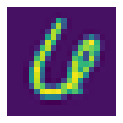

In [15]:
plot_number(3382)

# Multiclass Logistic Regression with Scikit-learn

In [16]:
classifier = LogisticRegression(C=10, penalty='l2', solver='liblinear')
# Intercept is fitted by default, so we are excluding the first column.
classifier.fit(X[:,1:],y.flatten())

/home/cagri/anaconda3/envs/my_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
pred2 = clf.predict(X[:,1:])
print('Training set accuracy: {} %'.format(np.mean(pred2 == y.ravel())*100))

Training set accuracy: 96.5 %


# Neural Networks

In [18]:
weights = loadmat('data/ex3weights.mat')
weights.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [19]:
theta_1 = weights["Theta1"]
theta_2 = weights["Theta2"]

In [59]:
def forward_propagation(X, theta_1, theta_2):
    z2 = theta_1 @ X.T
    a2_without_bias = sigmoid(z2)
    a2 = np.c_[np.ones((X.shape[0], 1)), a2_without_bias.T]
    
    z3 = theta_2 @ a2.T
    a3 = sigmoid(z3)
    
    prediction = np.argmax(a3.T, axis=1)
    prediction[prediction == 10] = 0

    return prediction